<a href="https://colab.research.google.com/github/aminayusif/PurchaseIQ/blob/main/PurchaseIQ_CustomerSegmentation_Using_K_Means_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

This notebook performs customer segmentation using K-Means clustering on e-commerce consumer behavior data. It includes steps for data loading, exploration, preprocessing, clustering, cluster analysis, and anomaly detection using Isolation Forest. The goal is to identify distinct customer segments and unusual purchasing patterns to inform targeted marketing strategies.

Key Sections:

Data Loading and Exploration

Data Preprocessing

Customer Segmentation (K-Means Clustering)

Cluster Analysis and Interpretation

Anomaly Detection (Isolation Forest)

Marketing Recommendations based on Segments and Anomalies

### Data Loading and Exploration

#### Import common libaries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### Load dataset

In [11]:
df = pd.read_csv('/content/ECommerce_consumer behaviour.csv')
# Drop rows with any remaining null values after initial inspection
df.dropna(inplace=True)

In [12]:
# Display the first few rows and info
display(df.head())
display(df.info())

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name
22,1201011,147243,14,0,16,3.0,94,1,0,7,beverages,tea
23,1201011,147243,14,0,16,3.0,83,2,0,4,produce,fresh vegetables
24,1201011,147243,14,0,16,3.0,83,3,1,4,produce,fresh vegetables
25,1201011,147243,14,0,16,3.0,24,4,1,4,produce,fresh fruits
26,1201011,147243,14,0,16,3.0,120,5,1,16,dairy eggs,yogurt


<class 'pandas.core.frame.DataFrame'>
Index: 391486 entries, 22 to 418251
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                391486 non-null  int64  
 1   user_id                 391486 non-null  int64  
 2   order_number            391486 non-null  int64  
 3   order_dow               391486 non-null  int64  
 4   order_hour_of_day       391486 non-null  int64  
 5   days_since_prior_order  391486 non-null  float64
 6   product_id              391486 non-null  int64  
 7   add_to_cart_order       391486 non-null  int64  
 8   reordered               391486 non-null  int64  
 9   department_id           391486 non-null  int64  
 10  department              391486 non-null  object 
 11  product_name            391486 non-null  object 
dtypes: float64(1), int64(9), object(2)
memory usage: 38.8+ MB


None

### Data Preprocessing

Let's check for null values in the dataset

In [13]:
df.isnull().sum()

,0
order_id,0
user_id,0
order_number,0
order_dow,0
order_hour_of_day,0
days_since_prior_order,0
product_id,0
add_to_cart_order,0
reordered,0
department_id,0


Displaying the unique values in the '**days_since_prior_order**' column to inspect its contents

In [14]:
df['days_since_prior_order'].unique()

array([ 3.,  6.,  7., 30., 20.,  4.,  8., 15., 10., 28.,  9., 12., 11.,
        2., 25., 13., 29., 14., 21.,  5.,  1., 18.,  0., 19., 17., 22.,
       26., 24., 16., 23., 27.])

We have filled the null values in the **days_since_prior_order** column with 0, as these likely represent a user's first order where there is no prior order to calculate the days since.

In [15]:
df['days_since_prior_order'] = df['days_since_prior_order'].fillna(0)

We now have no null values in our dataset

In [16]:
df.isnull().sum()

,0
order_id,0
user_id,0
order_number,0
order_dow,0
order_hour_of_day,0
days_since_prior_order,0
product_id,0
add_to_cart_order,0
reordered,0
department_id,0


We will also clean the 'department' column by removing leading/trailing spaces

In [17]:

df['department'] = df['department'].str.strip()

We will now convert **days_since_prior_order** from float to integer data type

In [18]:
df['days_since_prior_order']= df['days_since_prior_order'].astype(np.int64)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391486 entries, 22 to 418251
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   order_id                391486 non-null  int64 
 1   user_id                 391486 non-null  int64 
 2   order_number            391486 non-null  int64 
 3   order_dow               391486 non-null  int64 
 4   order_hour_of_day       391486 non-null  int64 
 5   days_since_prior_order  391486 non-null  int64 
 6   product_id              391486 non-null  int64 
 7   add_to_cart_order       391486 non-null  int64 
 8   reordered               391486 non-null  int64 
 9   department_id           391486 non-null  int64 
 10  department              391486 non-null  object
 11  product_name            391486 non-null  object
dtypes: int64(10), object(2)
memory usage: 38.8+ MB


### Customer Behavior Analysis

We examine unique values and their counts for categorical columns to understand the distribution and variety of data within those columns

In the context of customer segmentation, understanding the distribution of categories like '**department**' and '**order_dow**' can give us insights into customer preferences and behavior patterns related to the types of products they buy and the days they place orders.

In [20]:
# Examine unique values and their counts for categorical columns
for col in ['order_dow', 'order_hour_of_day', 'department', 'product_name']:
    if col in df.columns:
        display(f"Unique values and counts for column: {col}")
        display(df[col].value_counts())

'Unique values and counts for column: order_dow'

,count
order_dow,
0,77430
1,67726
6,53887
5,51075
2,50904
3,45642
4,44822


'Unique values and counts for column: order_hour_of_day'

,count
order_hour_of_day,
10,33699
11,33364
14,32924
15,32694
13,32610
12,31579
16,30639
9,29419
17,24710


'Unique values and counts for column: department'

,count
department,
produce,114258
dairy eggs,65615
snacks,35061
beverages,32631
frozen,27014
pantry,22633
bakery,14023
canned goods,12755
deli,12578


'Unique values and counts for column: product_name'

,count
product_name,
fresh fruits,44193
fresh vegetables,41370
packaged vegetables fruits,21033
yogurt,17806
packaged cheese,11731
...,...
kitchen supplies,112
eye ear care,109
baby accessories,96


The value counts for '**department**','**order_hour_of_day**','**product_name**' and '**order_dow**' show the frequency of each category.

'Produce' is the most frequent department, and day '0' (likely Sunday) is the most frequent order day of the week.

Based on the output for 'order_hour_of_day', it appears that the peak hours for placing orders are around 10 AM to 4 PM (hours 10 through 16), with the counts being significantly higher during this period compared to early morning or late night hours. This suggests that customers are most active during typical working or daytime hours.

#### Visualizing Order Counts by Hour of the Day

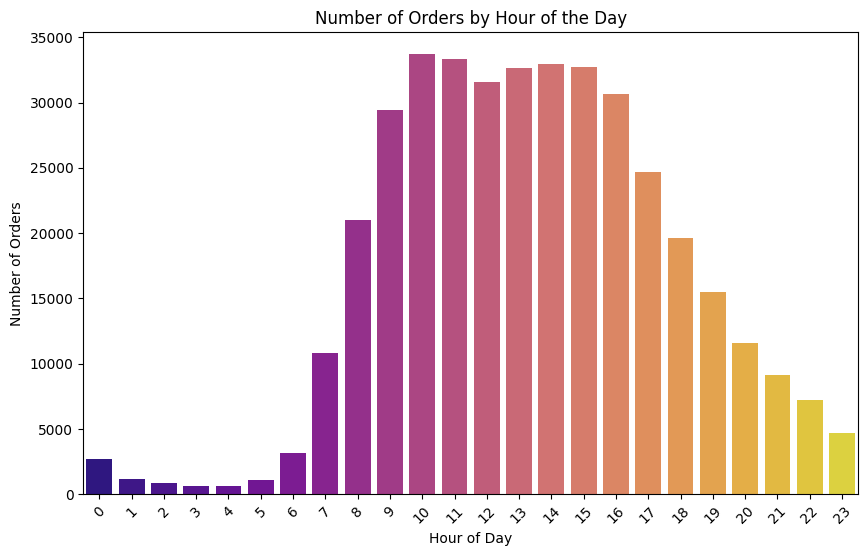

In [21]:
# Count the number of orders for each hour of the day
orders_by_hour = df['order_hour_of_day'].value_counts().sort_index()

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=orders_by_hour.index, y=orders_by_hour.values, palette='plasma')
plt.title('Number of Orders by Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()

#### Visualizing Number of Orders by Day of the Week

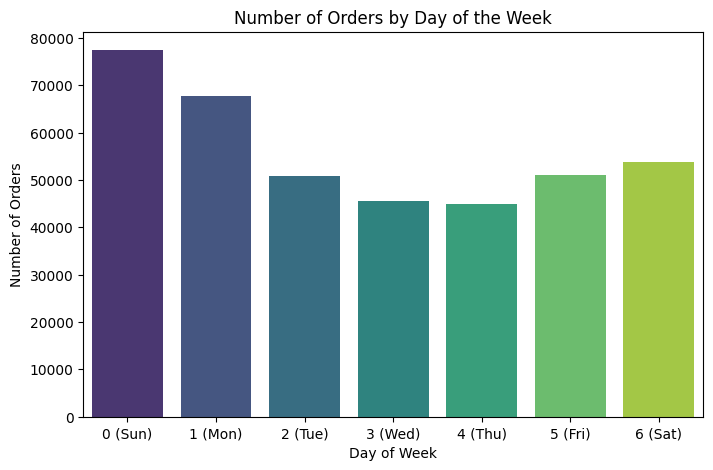

In [22]:
# Count the number of orders for each day of the week
orders_by_day = df['order_dow'].value_counts().sort_index()

# Create a bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=orders_by_day.index, y=orders_by_day.values, palette='viridis')
plt.title('Number of Orders by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.xticks(ticks=orders_by_day.index, labels=['0 (Sun)', '1 (Mon)', '2 (Tue)', '3 (Wed)', '4 (Thu)', '5 (Fri)', '6 (Sat)'])
plt.show()

#### Visualizing Top 20 Most Ordered Products

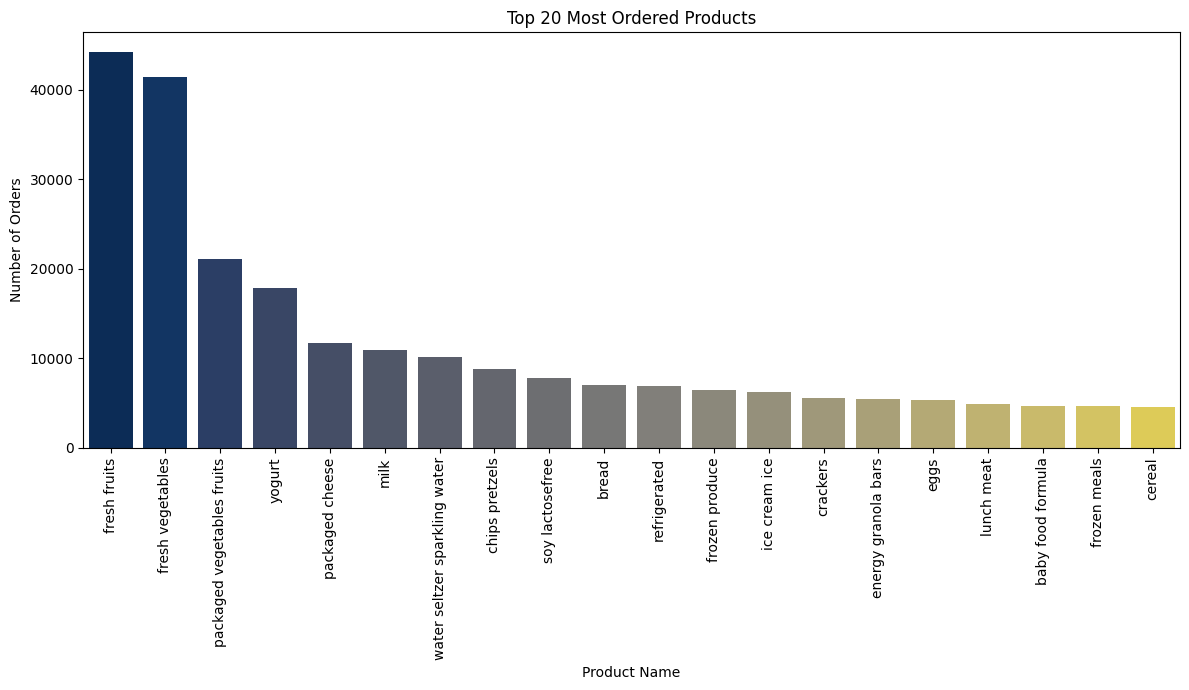

In [23]:
# Count the number of orders for each product and get the top 20
top_products = df['product_name'].value_counts().head(20)

# Create a bar chart
plt.figure(figsize=(12, 7))
sns.barplot(x=top_products.index, y=top_products.values, palette='cividis')
plt.title('Top 20 Most Ordered Products')
plt.xlabel('Product Name')
plt.ylabel('Number of Orders')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Visualizing Order Counts by Department

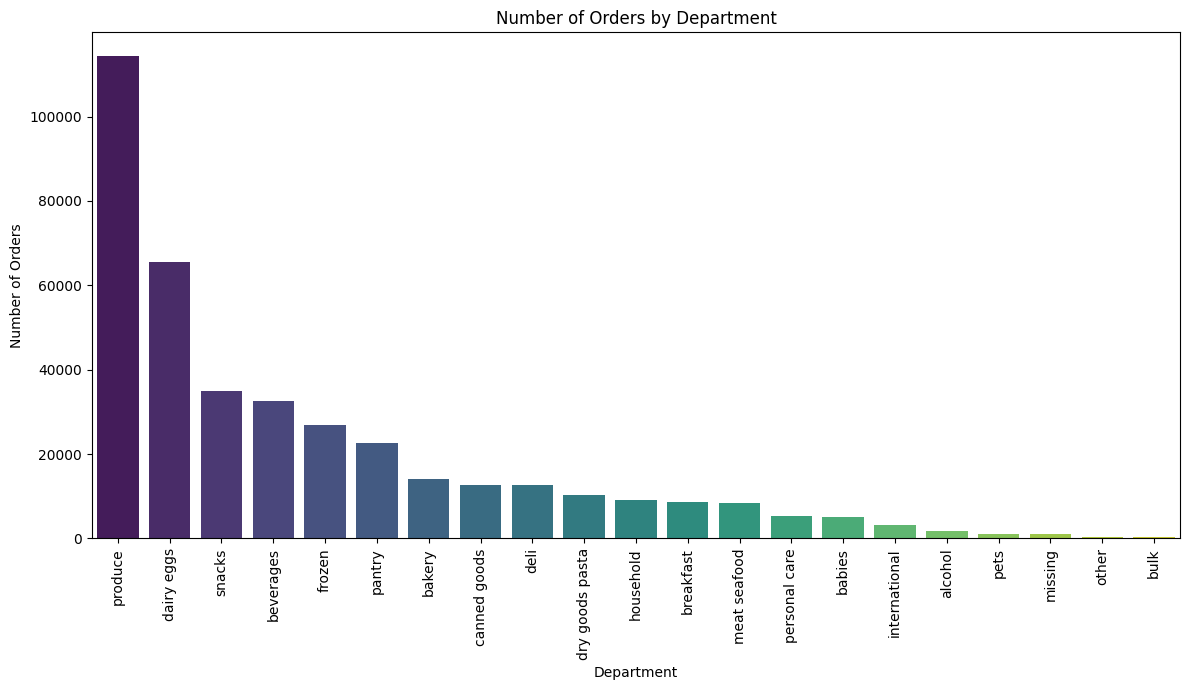

In [24]:
# Count the number of orders for each department
orders_by_department = df['department'].value_counts()

# Create a bar chart
plt.figure(figsize=(12, 7))
sns.barplot(x=orders_by_department.index, y=orders_by_department.values, palette='viridis')
plt.title('Number of Orders by Department')
plt.xlabel('Department')
plt.ylabel('Number of Orders')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Data Preprocessing

In [25]:
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# 3. Encode categorical features
categorical_features = ['department', 'order_dow']
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

# 4. Select numerical columns that are suitable for scaling
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
# Exclude identifier columns
numerical_features = [col for col in numerical_features if col not in ['order_id', 'user_id', 'product_id', 'department_id']]

# 5. Scale the selected numerical features using StandardScaler
scaler = StandardScaler()

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_features),
        ('cat', one_hot_encoder, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (like IDs) as they are
)

# Create a pipeline to apply the preprocessing steps
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
df_processed = preprocessing_pipeline.fit_transform(df)

# Convert the processed data back to a DataFrame for easier handling (optional, but often useful)
# Get the new column names after one-hot encoding
new_column_names = numerical_features + list(preprocessing_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
# Add back the columns that were passed through
passthrough_cols = [col for col in df.columns if col not in numerical_features + categorical_features]
new_column_names += passthrough_cols

df_processed = pd.DataFrame(df_processed, columns=new_column_names, index=df.index)

display(df_processed.head())
display(df_processed.shape)
display(df_processed.isnull().sum().sum()) # Check for any remaining missing values

,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,department_alcohol,department_babies,department_bakery,department_beverages,...,order_dow_2,order_dow_3,order_dow_4,order_dow_5,order_dow_6,order_id,user_id,product_id,department_id,product_name
22,-0.244309,-1.296478,0.616192,-0.938668,-1.03552,-1.296678,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1201011,147243,94,7,tea
23,-0.244309,-1.296478,0.616192,-0.938668,-0.89508,-1.296678,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1201011,147243,83,4,fresh vegetables
24,-0.244309,-1.296478,0.616192,-0.938668,-0.754639,0.771201,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1201011,147243,83,4,fresh vegetables
25,-0.244309,-1.296478,0.616192,-0.938668,-0.614199,0.771201,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1201011,147243,24,4,fresh fruits
26,-0.244309,-1.296478,0.616192,-0.938668,-0.473758,0.771201,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1201011,147243,120,16,yogurt


(391486, 39)

np.int64(0)

### Principal Component Analysis (PCA)

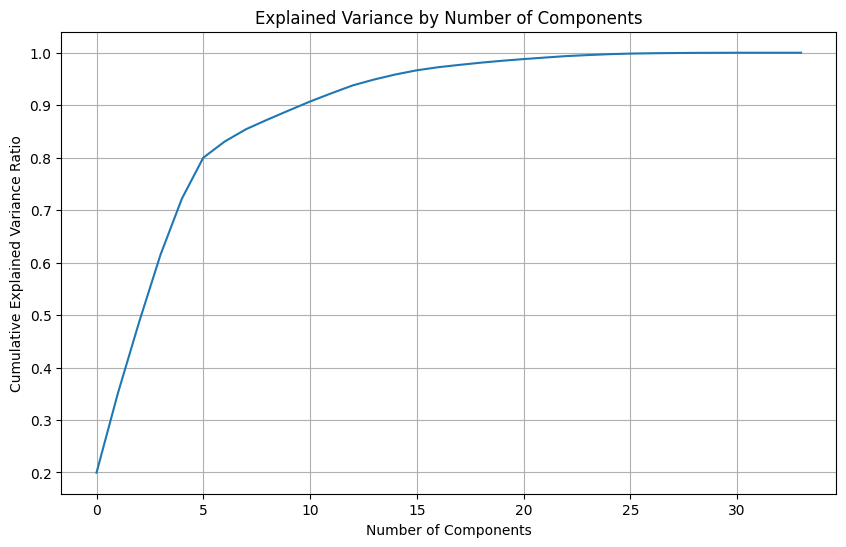

Number of components explaining at least 95% variance: 15


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,user_id
22,-0.173300,-1.129506,-0.569458,0.868392,-1.929589,-0.081377,-0.190373,-0.579244,-0.111276,-0.449410,-0.072017,-0.093846,0.021046,-0.605910,-0.571099,147243
23,-0.184507,-1.145010,-0.458607,0.906703,-1.834837,-0.122767,0.795703,-0.564537,-0.244903,0.077451,0.078085,-0.054098,0.012728,0.026260,-0.062958,147243
24,0.808098,-1.328621,-1.003648,0.651633,-0.275714,-0.804120,0.730703,-0.564366,-0.213311,0.003185,0.044979,-0.047047,0.013564,0.028424,-0.019926,147243
25,0.780905,-1.330375,-0.890530,0.688607,-0.212235,-0.831723,0.730090,-0.562916,-0.212022,0.006008,0.045829,-0.045476,0.013599,0.026083,-0.021753,147243
26,0.747124,-1.323180,-0.784079,0.721310,-0.166062,-0.852457,-0.573423,-0.637145,-0.397460,0.501283,0.173575,-0.028781,0.001922,0.036525,-0.055903,147243


In [26]:
from sklearn.decomposition import PCA

# Separate features from identifiers
features_df = df_processed.drop(['order_id', 'user_id', 'product_id', 'department_id', 'product_name'], axis=1)

# Initialize PCA and fit to the processed data
pca = PCA()
pca.fit(features_df)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()

# Choose the number of components based on the elbow point or a desired explained variance
# For example, let's choose components that explain 95% of the variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components explaining at least 95% variance: {n_components}")

# Re-run PCA with the selected number of components
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(features_df)

# Create a new DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)], index=df_processed.index)

# You might want to add back user_id or other identifiers for later analysis
pca_df['user_id'] = df_processed['user_id']

display(pca_df.head())

The output **Number of components explaining at least 95% variance: 15** tells us that the first 15 principal components retain at least 95% of the total information (variance) present in the original 34 features (features_df has 34 columns after dropping the identifiers). This means we can effectively reduce the dimensionality of the dataset from 34 to 15 features while losing only a small amount of information (less than 5%). These 15 principal components capture the most significant patterns and variations in the customer behavior data.

### Determining the Optimal Number of Clusters using the Elbow Method

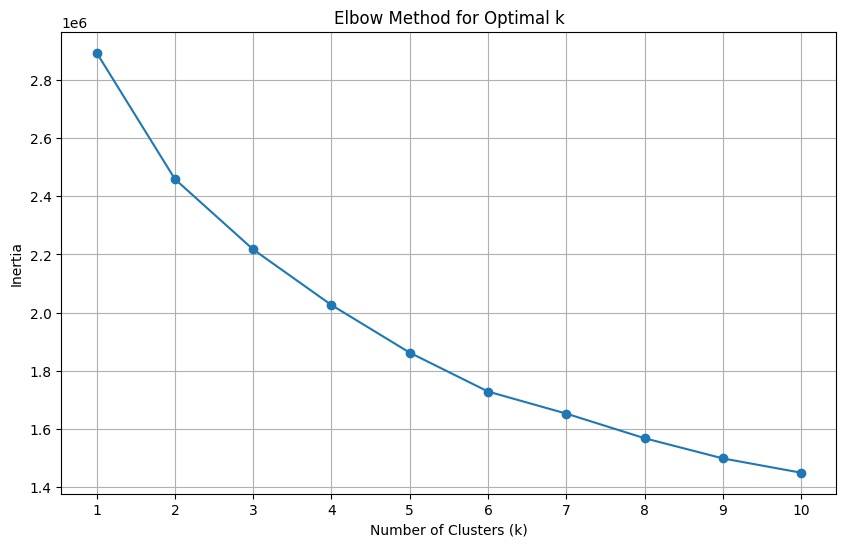

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# We will use the PCA-transformed data for clustering
X = pca_df.drop('user_id', axis=1)

# Determine the optimal number of clusters using the Elbow Method
inertia = []
# Experiment with a range of cluster numbers
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

### K-Means Clustering

In [29]:
# Based on the Elbow Method, choose an appropriate number of clusters (let's assume k=4 for now, adjust based on the plot)
optimal_k = 4 # This should be determined from the elbow plot

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
pca_df['cluster'] = kmeans.fit_predict(X)

display(pca_df.head())
display(pca_df['cluster'].value_counts())

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,user_id,cluster
22,-0.173300,-1.129506,-0.569458,0.868392,-1.929589,-0.081377,-0.190373,-0.579244,-0.111276,-0.449410,-0.072017,-0.093846,0.021046,-0.605910,-0.571099,147243,2
23,-0.184507,-1.145010,-0.458607,0.906703,-1.834837,-0.122767,0.795703,-0.564537,-0.244903,0.077451,0.078085,-0.054098,0.012728,0.026260,-0.062958,147243,2
24,0.808098,-1.328621,-1.003648,0.651633,-0.275714,-0.804120,0.730703,-0.564366,-0.213311,0.003185,0.044979,-0.047047,0.013564,0.028424,-0.019926,147243,3
25,0.780905,-1.330375,-0.890530,0.688607,-0.212235,-0.831723,0.730090,-0.562916,-0.212022,0.006008,0.045829,-0.045476,0.013599,0.026083,-0.021753,147243,3
26,0.747124,-1.323180,-0.784079,0.721310,-0.166062,-0.852457,-0.573423,-0.637145,-0.397460,0.501283,0.173575,-0.028781,0.001922,0.036525,-0.055903,147243,3


,count
cluster,
3,107356
1,106462
2,105383
0,72285


### Visualizing K-Means Clusters

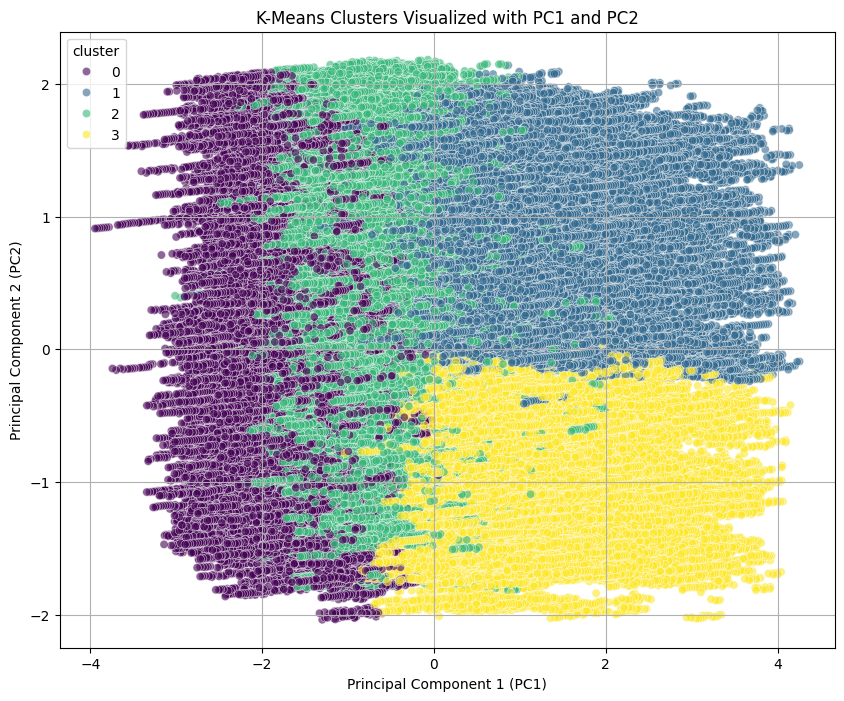

In [30]:
# Visualize the clusters using the first two principal components
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis', legend='full', alpha=0.6)
plt.title('K-Means Clusters Visualized with PC1 and PC2')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.grid(True)
plt.show()

### Cluster Analysis and Interpretation

In [31]:
# Merge cluster labels back to the original dataframe or a relevant subset
df_clustered = df.copy()
df_clustered['cluster'] = pca_df['cluster']

# Group by cluster and calculate the mean of relevant numerical features
cluster_analysis = df_clustered.groupby('cluster')[['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'add_to_cart_order', 'reordered']].mean()

display("Mean of numerical features per cluster:")
display(cluster_analysis)

# We can also look at the distribution of categorical features within each cluster
# For example, the distribution of departments
department_cluster_distribution = df_clustered.groupby('cluster')['department'].value_counts(normalize=True).unstack()

display("\nDistribution of departments per cluster:")
display(department_cluster_distribution)

# You can perform similar analysis for 'order_dow' as well
order_dow_cluster_distribution = df_clustered.groupby('cluster')['order_dow'].value_counts(normalize=True).unstack()

display("\nDistribution of order day of week per cluster:")
display(order_dow_cluster_distribution)

'Mean of numerical features per cluster:'

,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered
cluster,,,,,,
0,7.953725,2.618026,13.633769,27.615937,8.817085,0.472864
1,24.462465,4.615328,13.435301,7.424086,7.393258,0.986699
2,13.336383,2.775467,13.491237,7.917378,9.785165,0.000028
3,24.093223,0.850972,13.126402,7.847228,7.660718,0.989735


'\nDistribution of departments per cluster:'

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.004275,0.010403,0.034488,0.082050,0.022522,0.000872,0.037075,0.158221,0.031832,0.031113,...,0.027129,0.009186,0.023795,0.002103,0.001010,0.064398,0.015909,0.003306,0.278647,0.086311
1,0.005617,0.012728,0.038756,0.094127,0.020721,0.000996,0.024816,0.191373,0.032810,0.019631,...,0.016212,0.005091,0.019998,0.002113,0.000789,0.034632,0.008379,0.003109,0.317475,0.087646
2,0.005229,0.014851,0.031476,0.067516,0.023761,0.001006,0.044201,0.127943,0.030413,0.035736,...,0.035822,0.013835,0.022252,0.004109,0.001680,0.101563,0.024188,0.002638,0.237790,0.095461
3,0.003949,0.013832,0.038070,0.089087,0.020921,0.000978,0.025849,0.189286,0.033338,0.021145,...,0.014680,0.005356,0.020623,0.001490,0.000810,0.033422,0.007033,0.002515,0.328421,0.087848


'\nDistribution of order day of week per cluster:'

order_dow,0,1,2,3,4,5,6
cluster,,,,,,,
0,0.204538,0.169274,0.146088,0.128934,0.111517,0.114187,0.125462
1,NaN,NaN,NaN,0.218839,0.227105,0.273948,0.280109
2,0.189101,0.166716,0.129300,0.123587,0.119403,0.129584,0.142309
3,0.397900,0.353227,0.248873,NaN,NaN,NaN,NaN


Based on the analysis of these DataFrames, here is an interpretation of the identified customer segments:







**Cluster 0: Infrequent Shoppers or possibly New Customers**  

Characteristics: This cluster seems to represent Infrequent Shoppers or possibly New Customers. They have the lowest average order_number (around 8), indicating fewer orders placed. They also have the highest average days_since_prior_order (around 27.6), suggesting long gaps between orders. Their reorder rate is relatively low (around 0.47). Their ordering behavior is spread across all days of the week and hours of the day, without a strong peak. They show a slightly higher proportion of purchases in the 'pantry' and 'household' departments compared to some other clusters.

Interpretation: These customers are not regular buyers. They might be one-time purchasers, occasional shoppers, or new users exploring the platform.

**Cluster 1: Frequent Reorderers, Weekend/Weekday Afternoon Shoppers**

Characteristics: This cluster appears to be Frequent Reorderers, Weekend/Weekday Afternoon Shoppers. They have a high average order_number (around 24.5) and a very high reorder rate (around 0.98). Their days_since_prior_order is low (around 7.4), indicating frequent purchases. They show a preference for ordering on days 3, 4, 5, and 6 (Wednesday to Saturday) and during the afternoon hours. They have a higher proportion of purchases in 'produce' and 'dairy eggs' departments.

Interpretation: These are loyal customers who frequently reorder items, likely staples, and tend to shop later in the week and on weekends during the afternoon.

**Cluster 2: New or Exploring Customers with Diverse Purchases**

Characteristics: This cluster could represent New or Exploring Customers with Diverse Purchases. They have a moderate average order_number (around 13.3) and a very low reorder rate (around 0.000028), which is a key differentiator.

Their days_since_prior_order is low (around 7.9), similar to the frequent reorderers, but this is likely because these are their initial orders. They have the highest average add_to_cart_order, suggesting they add more items to their cart per order. They have a higher proportion of purchases in 'pantry', 'household', and 'personal care' departments, and a lower proportion in 'produce' and 'dairy eggs' compared to other frequent clusters. Their ordering days are spread across the week, similar to Cluster 0.

Interpretation: These customers are likely in the early stages of their journey, trying out various products and departments, which results in a low reorder rate despite frequent initial orders. They are exploring the product catalog.

**Cluster 3: Highly Frequent Reorderers, Weekend/Early Week Shoppers**

Characteristics: This cluster represents Highly Frequent Reorderers, Weekend/Early Week Shoppers. They have a high average order_number (around 24.1) and a very high reorder rate (around 0.98), similar to Cluster 1. Their days_since_prior_order is also low (around 7.8), indicating frequent purchases. A key difference from Cluster 1 is their strong preference for ordering on days 0, 1, and 2 (Sunday to Tuesday). Like Cluster 1, they show a high proportion of purchases in 'produce' and 'dairy eggs'.

Interpretation: These are also loyal and frequent reordering customers, similar to Cluster 1, but they tend to do their shopping earlier in the week, particularly on Sundays and Mondays.

Summary of Segments:

Cluster 0: Infrequent/New Shoppers (Low order count, high days since prior order, low reorder rate, spread out shopping times)

Cluster 1: Frequent Reorderers (Late Week/Weekend) (High order count, low days since prior order, high reorder rate, prefer late week/weekend afternoons, focus on produce/dairy eggs)

Cluster 2: New/Exploring Customers (Moderate order count, low days since prior order for initial orders, very low reorder rate, high items per order, diverse department purchases, spread out shopping times)

Cluster 3: Highly Frequent Reorderers (Early Week) (High order count, low days since prior order, high reorder rate, prefer early week/weekends, focus on produce/dairy eggs)

### Visualizing Cluster Profiles

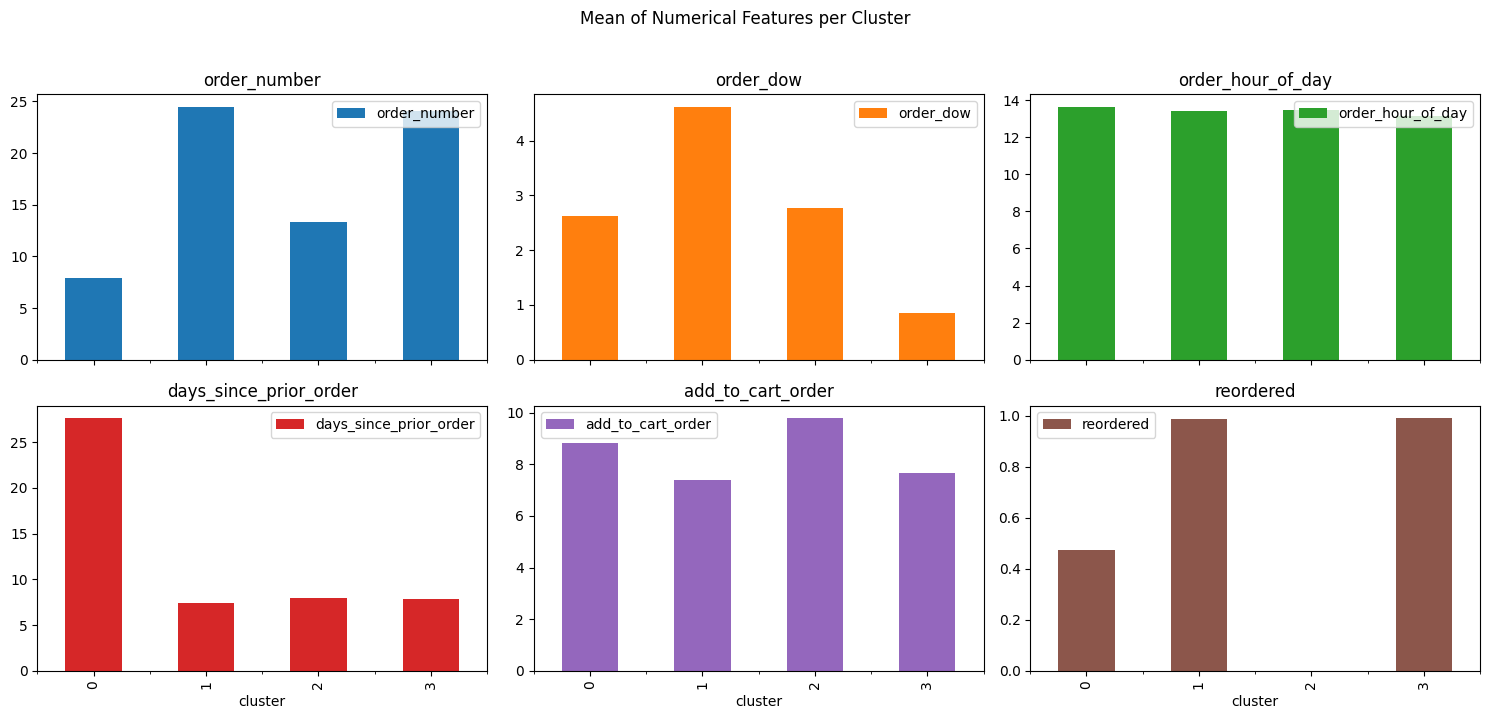

In [32]:
# Visualize the mean of numerical features per cluster
cluster_analysis.plot(kind='bar', figsize=(15, 7), subplots=True, layout=(2, 3), sharey=False)
plt.suptitle('Mean of Numerical Features per Cluster', y=1.02)
plt.tight_layout()
plt.show()

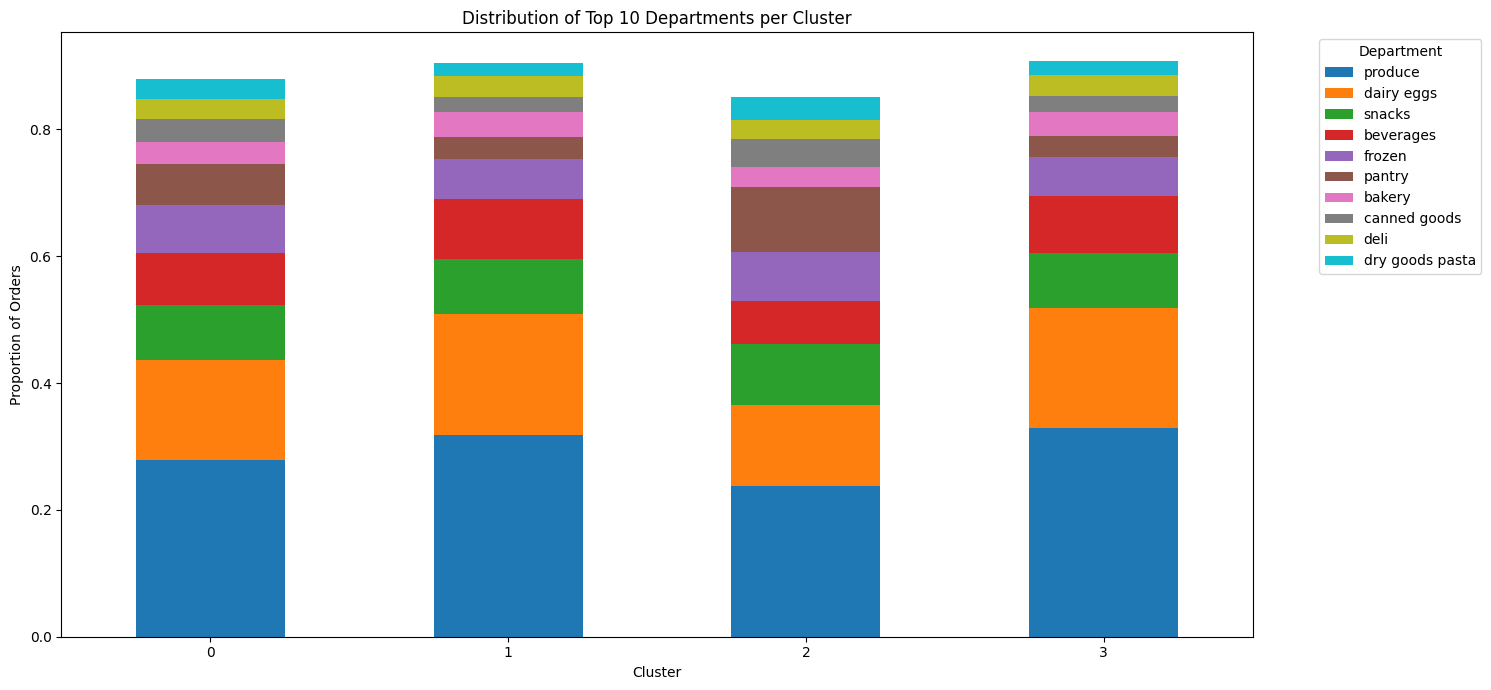

In [33]:
# Visualize the distribution of top departments per cluster
# Select top N departments for better visualization
top_departments = department_cluster_distribution.sum().sort_values(ascending=False).head(10).index
department_cluster_distribution[top_departments].plot(kind='bar', figsize=(15, 7), stacked=True)
plt.title('Distribution of Top 10 Departments per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion of Orders')
plt.xticks(rotation=0)
plt.legend(title='Department', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

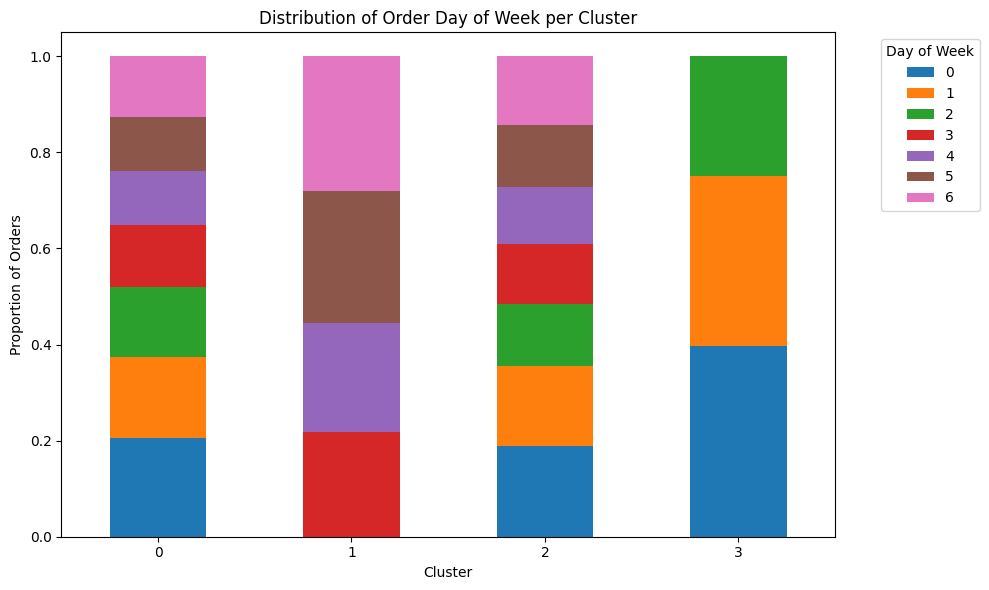

In [34]:
# Visualize the distribution of order day of week per cluster
order_dow_cluster_distribution.plot(kind='bar', figsize=(10, 6), stacked=True)
plt.title('Distribution of Order Day of Week per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion of Orders')
plt.xticks(ticks=[0, 1, 2, 3], labels=['0', '1', '2', '3'], rotation=0) # Assuming clusters are 0, 1, 2, 3
plt.legend(title='Day of Week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Recommendations for each cluster for future marketing purposes

By tailoring marketing efforts to the specific behaviors and preferences of each cluster, the e-commerce platform can improve customer engagement, increase loyalty, and drive sales more effectively.

**Cluster 0: Infrequent/New Shoppers**

Characteristics: Low order count, long gaps between orders, low reorder rate, exploring diverse departments.

Marketing Recommendations:

Focus on Retention and Engagement: Implement welcome email series, onboarding guides, and educational content about the platform and product variety.

Incentivize Repeat Purchases: Offer discounts or special offers on their second or third order to encourage them to become more regular.


Personalized Recommendations:

 Leverage their browsing and initial purchase history to provide tailored product suggestions and introduce them to relevant departments.

Highlight Benefits of Regular Shopping:

Communicate the value of frequent purchases, such as loyalty programs, subscription options (if available), or faster checkout for returning customers.

**Cluster 1: Frequent Reorderers (Late Week/Weekend)**

Characteristics: High order count, frequent purchases, high reorder rate, prefer late week/weekend afternoons, focus on produce/dairy eggs.

Marketing Recommendations:

Reward Loyalty: Implement a strong loyalty program that rewards frequent purchases and high spending.

Subscription Services: Promote subscription options for their frequently reordered items (produce, dairy eggs) for convenience and potential cost savings.

Targeted Promotions: Offer promotions and discounts on items within their preferred departments (produce, dairy eggs) and related categories.

Weekend/Afternoon Specific Campaigns: Schedule marketing campaigns and notifications to align with their preferred shopping times.

Introduce Complementary Products: Suggest new or complementary products within their preferred departments or related categories to increase basket size.

**Cluster 2: New/Exploring Customers**

Characteristics: Moderate order count, frequent initial orders, very low reorder rate, high items per order, diverse department purchases.

Marketing Recommendations:

Encourage Reordering: Focus on converting these exploratory purchases into repeat business. Offer incentives for reordering specific items they've purchased.

Curated Discovery: Provide curated product lists or bundles based on their diverse purchase history to help them discover more relevant products.

Educational Content: Offer tips and information related to the departments they've explored to build confidence and encourage further purchases.

Gather Feedback: Reach out to these customers to understand their experience and identify any barriers to reordering.

Highlight Benefits of Specific Categories: Promote the benefits of regularly purchasing from departments they've shown interest in, emphasizing quality, freshness, or value.

**Cluster 3: Highly Frequent Reorderers (Early Week)**

Characteristics: High order count, frequent purchases, high reorder rate, prefer early week/weekends, focus on produce/dairy eggs.

Marketing Recommendations:

Similar to Cluster 1, but with a different timing focus: Implement loyalty programs, promote subscriptions, and offer targeted promotions on produce and dairy eggs.
Early Week Specific Campaigns: Schedule marketing campaigns and notifications to align with their preferred shopping times (Sunday to Tuesday).

Streamline Early Week Shopping: Optimize the user experience for early-week shopping, perhaps with quick reorder options or reminders.

Introduce Premium or Specialty Items: Since they are frequent buyers of staples, introduce them to premium or specialty items within their preferred departments to increase average order value.